<a href="https://colab.research.google.com/github/ianuhs/Pneumonia-Classifier/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Training a Pneumonia Classifier with PyTorch**





In [ ]:
pip install torch torchvision pillow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import multiprocessing

multiprocessing.cpu_count()

2

In [ ]:
!unzip -q /content/drive/MyDrive/data.zip -d /content/


In [ ]:
import os

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class PneumoniaDataset(Dataset):

  def __init__(self, root_dir, transform=None):

      self.root_dir = root_dir
      self.transform = transform
      self.image_paths = []
      self.labels = []

      for label in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join (root_dir, label)
        for img_name in os.listdir(class_dir):
            self.image_paths.append(os.path.join(class_dir, img_name))
            self.labels.append(0 if label == 'NORMAL' else 1)

  def __len__(self):
      return len(self.image_paths)

  def __getitem__(self, idx):
      img_path = self.image_paths[idx]
      image = Image.open(img_path).convert('RGB')
      label = self.labels[idx]

      if self.transform:
        image = self.transform(image)

      return image, label


transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = PneumoniaDataset(root_dir='/content/data/train', transform=transform)
val_dataset = PneumoniaDataset(root_dir='/content/data/val', transform=transform)
test_dataset = PneumoniaDataset(root_dir='/content/data/test', transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=128)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=128)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=128)

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2) #NORMAL, PNEUMONIA
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epoch = 10

for epoch in range(num_epoch):
  model.train()
  running_loss = 0.0

  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()

    running_loss += loss

  print(f"Epoch {epoch + 1}/{num_epoch}, Loss: {running_loss/len(train_loader)}")

  model.eval()
  val_labels = []
  val_preds = []

  with torch.no_grad():
    for images,labels in val_loader:

      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, prds = torch.max(outputs, 1)

      val_labels.extend(labels.cpu().numpy())
      val_preds.extend(prds.cpu().numpy())

  val_accuracy = accuracy_score(val_labels, val_preds)
  print('Validation accuracy:', val_accuracy)


model.eval()
test_labels = []
test_preds = []

with torch.no_grad():
    for images,labels in test_loader:

      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, prds = torch.max(outputs, 1)

      test_labels.extend(labels.cpu().numpy())
      test_preds.extend(prds.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
print('Test accuracy:', test_accuracy)

torch.save(model.state_dict(), 'pneumonia_classifier.pth')

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 96, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10, Loss: 0.12685555219650269
Validation accuracy: 0.6875


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 96, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/10, Loss: 0.06168675422668457
Validation accuracy: 0.9375


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 96, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/10, Loss: 0.05457177758216858
Validation accuracy: 0.9375


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 96, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/10, Loss: 0.047474853694438934
Validation accuracy: 1.0


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 96, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/10, Loss: 0.030853988602757454
Validation accuracy: 1.0


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 96, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/10, Loss: 0.021360216662287712
Validation accuracy: 1.0


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 96, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/10, Loss: 0.022197002544999123
Validation accuracy: 0.8125


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 96, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/10, Loss: 0.01981491781771183
Validation accuracy: 0.9375


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 96, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/10, Loss: 0.015036175027489662
Validation accuracy: 0.75


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 96, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/10, Loss: 0.020369963720440865
Validation accuracy: 1.0


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 96, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test accuracy: 0.7516025641025641


In [ ]:
# Data based on your logs
epochs = list(range(1, 11))
losses = [
    0.12685555219650269, 0.06168675422668457, 0.05457177758216858,
    0.047474853694438934, 0.030853988602757454, 0.021360216662287712,
    0.022197002544999123, 0.01981491781771183, 0.015036175027489662,
    0.020369963720440865
]

val_accuracies = [
    0.6875, 0.9375, 0.9375, 1.0, 1.0, 1.0,
    0.8125, 0.9375, 0.75, 1.0
]

# Test accuracy (same value across all epochs just for display)
test_accuracy = 0.7516025641025641


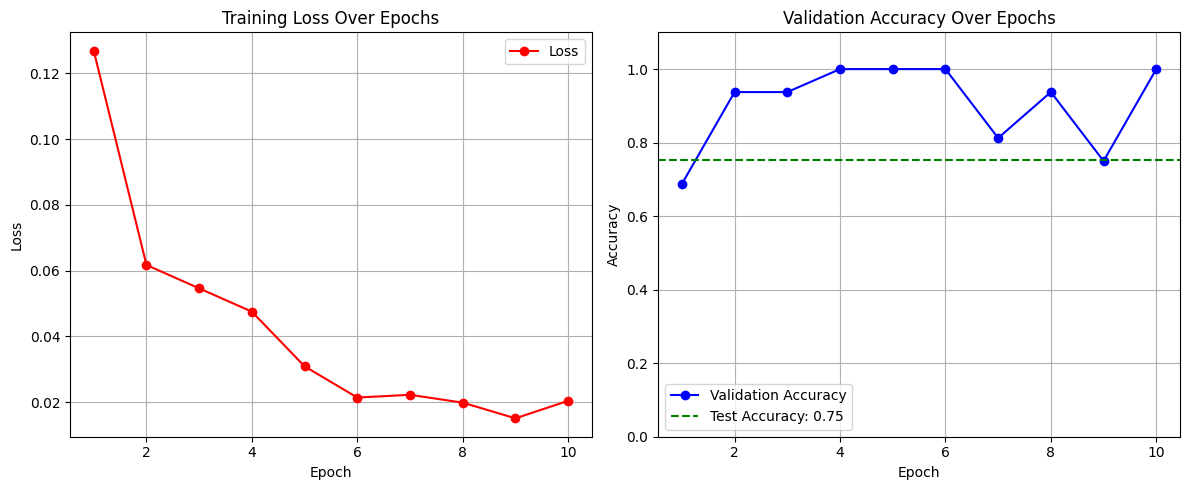

In [ ]:
import matplotlib.pyplot as plt

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, marker='o', color='red', label='Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, marker='o', color='blue', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='green', linestyle='--', label=f'Test Accuracy: {test_accuracy:.2f}')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Remove the folder if it already exists
!rm -rf Pneumonia-Classifier

# Clone your GitHub repo
!git clone https://github.com/ianuhs/Pneumonia-Classifier.git

# Copy your notebook into the repo
!cp train_model.ipynb Pneumonia-Classifier/

# Move into the repo directory
%cd Pneumonia-Classifier

# Set up Git credentials (do this once)
!git config --global user.name "ianuhs"
!git config --global user.email "ianfong125@gmail.com"

# Stage and commit the notebook
!git add train_model.ipynb
!git commit -m "Initial commit from Colab"

# Create and push the main branch
!git branch -M main
!git push origin main



Cloning into 'Pneumonia-Classifier'...
cp: cannot stat 'train_model.ipynb': No such file or directory
/content/Pneumonia-Classifier/Pneumonia-Classifier
fatal: pathspec 'train_model.ipynb' did not match any files
On branch main

Initial commit

nothing to commit (create/copy files and use "git add" to track)
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/ianuhs/Pneumonia-Classifier.git'


In [ ]:
!find /content -name train_model.ipynb
